In [19]:
import pandas as pd

train = pd.read_csv('dm2_dataset_2425_imdb/train70_clf.csv')
test = pd.read_csv('dm2_dataset_2425_imdb/test30_clf.csv')

In [20]:
train.columns

Index(['startYear', 'runtimeMinutes', 'canHaveEpisodes', 'numRegions',
       'ratingCount', 'companiesNumber', 'averageRating', 'totalNominations',
       'totalMedia', 'totalReviews', 'Asia', 'Africa', 'Europe',
       'North America', 'South America', 'Oceania', 'Continent Unknown',
       'genre1', 'genre2', 'genre3', 'deltaCredits', 'titleType'],
      dtype='object')

In [21]:
X_train = train.drop(columns=['averageRating', 'canHaveEpisodes'])
y_train = train['averageRating']

X_test = test.drop(columns=['averageRating', 'canHaveEpisodes'])
y_test = test['averageRating']

# One-hot encode titleType
X_train = pd.get_dummies(X_train, columns=['titleType'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['titleType'], drop_first=True)

In [22]:
X_train.columns

Index(['startYear', 'runtimeMinutes', 'numRegions', 'ratingCount',
       'companiesNumber', 'totalNominations', 'totalMedia', 'totalReviews',
       'Asia', 'Africa', 'Europe', 'North America', 'South America', 'Oceania',
       'Continent Unknown', 'genre1', 'genre2', 'genre3', 'deltaCredits',
       'titleType_short', 'titleType_tvEpisode', 'titleType_tvMiniSeries',
       'titleType_tvMovie', 'titleType_tvSeries', 'titleType_tvShort',
       'titleType_tvSpecial', 'titleType_video', 'titleType_videoGame'],
      dtype='object')

In [23]:
# Preprocessing
from sklearn.preprocessing import StandardScaler

non_bool = ['startYear', 'runtimeMinutes', 'numRegions', 'ratingCount',
       'companiesNumber', 'totalNominations', 'totalMedia', 'totalReviews',
       'Asia', 'Africa', 'Europe', 'North America', 'South America', 'Oceania',
       'Continent Unknown', 'genre1', 'genre2', 'genre3', 'deltaCredits']

scaler = StandardScaler()
X_train[non_bool] = scaler.fit_transform(X_train[non_bool])
X_test[non_bool] = scaler.transform(X_test[non_bool])

In [24]:
# Preprocess the target variable
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

In [25]:
from tensorflow import keras
from tensorflow.keras import layers

max_val = y_train.max()
min_val = y_train.min()

model = keras.Sequential([
    layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid'),  # Regression output
    layers.Lambda(lambda x: x * (max_val - min_val) + min_val)  # Scale output back to original range
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
history = model.fit(X_train, y_train, epochs=2, batch_size=32, validation_split=0.2)
model.evaluate(X_test, y_test)

Epoch 1/2
2617/2617 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.8827 - mae: 0.7132 - val_loss: 0.7868 - val_mae: 0.6600
Epoch 2/2
2617/2617 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.7747 - mae: 0.6572 - val_loss: 0.7712 - val_mae: 0.6619
1402/1402 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step - loss: 0.7766 - mae: 0.6608


[0.7807108163833618, 0.6642575263977051]

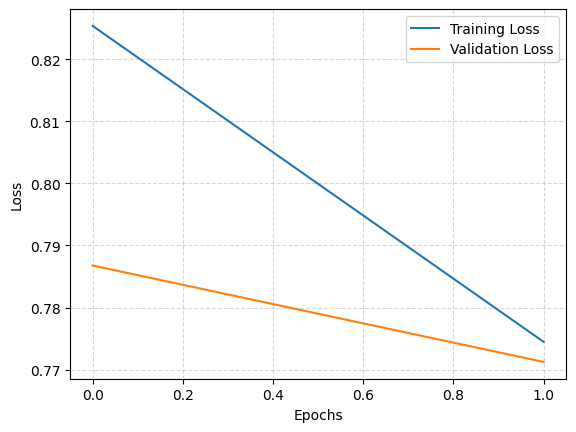

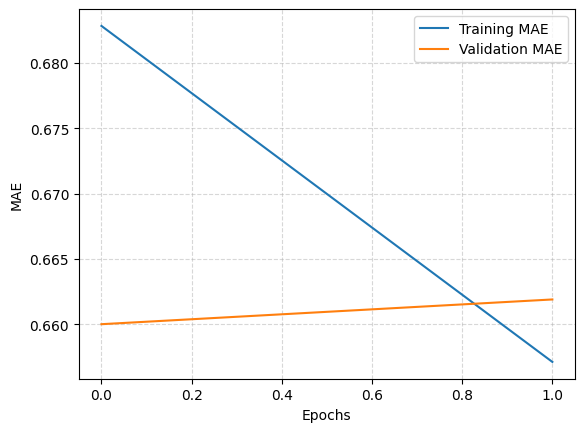

In [27]:
# Plot history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(alpha=0.5, linestyle='--')
plt.legend()
plt.show()

# Plot MAE
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.grid(alpha=0.5, linestyle='--')
plt.legend()
plt.show()

In [28]:
# R-squared, MSE and MAE computation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R-squared: {r2}')

1402/1402 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step
MSE: 0.7807108859759783
MAE: 0.664257510674141
R-squared: 0.22792376594535346


In [29]:
# Reverse scale predictions
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test.reshape(-1, 1))

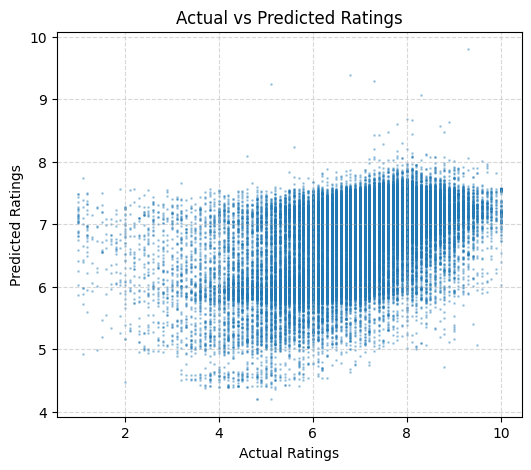

In [30]:
# Actual vs predicted plot
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred, alpha=0.3, s=1, edgecolors=None)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs Predicted Ratings')
plt.grid(alpha=0.5, linestyle='--')
plt.show()

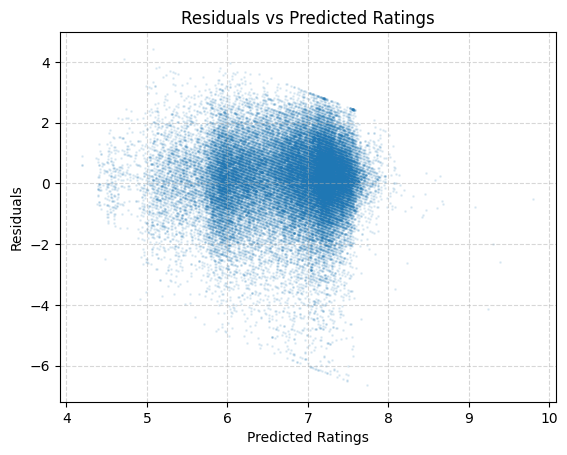

In [31]:
# Residual plot
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.1, s=1, edgecolors=None)
# plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Ratings')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Ratings')
plt.grid(alpha=0.5, linestyle='--')
plt.show()